In [1]:
import tidy3d as td
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# %matplotlib widget

In [2]:
import tidy3d.web as web
import os
api_key = os.environ.get("TIDY3D_API_KEY")
# web.configure("_blank_")
web.configure(api_key)

Configured successfully.


In [3]:
web.test()

06:54:18 UTC Authentication configured successfully!

In [4]:
# Planck's constant in Js
h = 6.62607015e-34
# Elementary charge in C
e = 1.602176634e-19

# Energy in eV = (frequency_hz * h) / e
def hz_to_ev(frequency_hz):
    '''Args: (float or np.ndarray)'''
    return (frequency_hz * h) / e

def ev_to_hz(energy_ev):
    return (energy_ev * e) / h

In [25]:
save_dir = '/app/local_project/siHoles_offset'
os.makedirs(save_dir, exist_ok=True)

name  = '/miniMon_dipolEx_L25_Hxyz'
name0 = name + '_empty'

#######====== Define parameter for 60nm diameter experiments ==============####
# Cavity parameters
rad        = 0.030                              # radius in um
thickness  = 0.025                              # 0.025 um, 0.100 um
pol_value  = 'Ex'                     # dipole sources

# pitch   =            # single
# gap     = 0.030      # 0.015, 0.030

In [24]:
######============ Define frequency range ==============####
# lambda_min, lambda_max = 0.05100133171603893, 0.3195468438892323 #24eV to 3.88eV
lambda_min, lambda_max = 0.056, 0.690 # 22eV to 2eV
freq_max, freq_min = td.C_0/lambda_min, td.C_0/lambda_max

freqs = np.linspace(freq_min, freq_max, 201)  # 201 frequency points
freq_0     = (freq_max+freq_min)/2            # source centre-frequency
freq_width = (freq_max-freq_min)


##### Rule of thumb: run_time should be at least 10-20 periods of max_lambda
n_periods = 20
required_time = n_periods / freq_min
print(f"Suggested minimum run_time: {required_time:.3e} seconds")   # 4.603e-14 = 46 fs

# Run_time = 2.01739e-14 # original
Run_time = 5e-13


######============ Simulation parameters ==============####
# auto-termination when field energy drops below val_Shutoff
'### (Default = 1e-5)'
# val_Shutoff = 0               #  0 = disable auto-termination for high-Q resonant structures
val_Shutoff = 1e-5            ### Default

# Index of source to normalize by 
'###(Default is 0 = first source, 1 = second source)'
val_NORM = 0 

'### Default = None' ## no apodization on monitors no time cutoff
val_Apodization = td.ApodizationSpec()  # no apodization
# val_Apodization = td.ApodizationSpec(start = 0.4e-15, width = 0.4e-15)  # start = 0.4fs, ramp 0.4fs

Suggested minimum run_time: 4.603e-14 seconds


In [7]:
# Material definition
Air = td.Medium(
    name = 'Air',
    permittivity = 1.000,
)
Si_Palik_4_poles = td.PoleResidue(
    name = 'Si_Palik_4-poles',
    frequency_range = [freq_min, freq_max],
    eps_inf = 1.0201315339282613,
    poles = [[(-230298116405116  -8124044914089037j), (-54468577807527.086 + 282082050889749.9j)], 
             [(-1689702290399004 -6497791373591796j), (22171856177039732   + 49896720261586410j)], 
             [(-222926848767196.12-6425424240903650j), (1710560534805847.5 + 3334591681401622.5j)], 
             [(-742335363792465.5 -6679004751836012j), (-22116228281991896 - 5135107205058006j)]]
)

In [9]:
# Dipole position Functions: random_points_in_cylinder, vertical_line_dipoles
def random_points_in_cylinder(center, radius, length, n_points,spacing=0.005):
    # Function to sample random points inside a cylinder
    """
    center: (x, y, z) of cylinder center
    radius: cylinder radius
    length: cylinder length (along z)
    """
    cx, cy, cz = center
    spacing = spacing   # 5nm buffer from cavity_edge 

    # Random radius (with sqrt for uniform area distribution)
    points = []
    for _ in range(n_points):
        #maximum radius used is radius - spacing
        r = (radius-spacing) * np.sqrt(np.random.rand()) 
        theta = 2 * np.pi * np.random.rand()
        
        x = cx + r * np.cos(theta)
        y = cy + r * np.sin(theta)
        z = cz + (np.random.rand() - 0.5) * length # Uniformly along z
        points.append([x, y, z])
        
    return points

def vertical_dipoles_in_cylinder(center, radius, length, n_points):
    # Function to create Z vertical line of dipoles
    """
    Places dipoles in a vertical line at the center with spacing from edge
    center: (x, y, z) of cylinder center
    radius: cylinder radius
    length: cylinder thickness (along z)
    """
    cx, cy, cz = center
    spacing = 0.005   # 5nm buffer from cavity edge 
    
    points = []
    # Calculate vertical spacing between dipoles
    available_length = length - 2 * spacing # Total available length 
    
    if n_points == 1:
        # Single dipole at center
        points.append([cx, cy, cz])
    else:
        # Multiple dipoles evenly spaced along z-axis
        z_spacing = available_length / (n_points - 1)
        for i in range(n_points):
            x = cx  # Center x position
            y = cy  # Center y position
            # Start from bottom (cz - available_length/2) and go up
            z = cz - available_length/2 + i * z_spacing
            points.append([x, y, z])
    
    return points    

In [26]:
#####=================================================
#####========= Sources definition ===========####

cavity_center = (0, 0, 0)  
# (rad-0.007, 0, 0)             # rad-7nm miniMon_edge
# paired_cavity_center = (2*rad+gap, 0, 0)

# Number of dipoles
n1 = 40
n2 = 0

# Fix random seed for reproducibility
np.random.seed(69) #42

# Generate Random positions
points_cavity         = random_points_in_cylinder(cavity_center, rad, thickness, n1, spacing=0.009)
# points_paired_cavity  = random_points_in_cylinder(paired_cavity_center, rad, thickness, n2, spacing=0.005)
All_points = points_cavity  #+ points_paired_cavity

# #Generate vertical dipole positions
# points_cavity_vert        = vertical_dipoles_in_cylinder(cavity_center, rad, thickness, n1,)
# # points_paired_cavity_vert = vertical_dipoles_in_cylinder(paired_cavity_center, rad, thickness, n2)
# All_points = points_cavity_vert  #+ points_paired_cavity_vert

# Create dipole sources at those position points
dipole_sources = []
for i, pos in enumerate(All_points):
    dip = td.PointDipole(
        name=f'pointdipole_{i}',
        center=pos,
        polarization=pol_value,
        source_time=td.GaussianPulse(
            freq0 = freq_0, 
            fwidth= freq_width),
        )
    
    dipole_sources.append(dip)
## Show all positions in {dipole_sources}
# for d in dipole_sources:
#     print(d.name, d.center)



###### ===============================##############################
# ================== Structure geometry ===========####
Slab = td.Structure(
    geometry = td.Box(
        center=(0,0,0),
        size = [td.inf, td.inf, thickness]),
    name = 'Slab',
    medium = Si_Palik_4_poles
)

Cavity = td.Structure(
    geometry = td.Cylinder(
        center=(0,0,0),
        radius = rad, length = thickness),
    name = 'Cavity',
    medium = Air
)

# Paired_cavity = td.Structure(
#     geometry = td.Cylinder(
#         center=(2*rad+gap,0,0),
#         radius = rad, length = thickness),
#     name = 'Paired_Cavity',
#     medium = Air
# )


###### ========================================= ###############
#####========= Monitors definition (seven total) ===========####
# Monitors
monitors = []

# Five in-plane miniMonitors at different heights within the slab
# length_mon = math.sqrt(0.5 * (rad+rad)**2)      # only inside cavity 

# for n in (0,1,2,3,4.5):                    # z-height positions
#     monitor = td.FieldMonitor(
#         name=f'DFT_in_plane_slice{n}',
#         center=[0,0, 0- n* (thickness/10)], 
#         size=[length_mon, length_mon, 0],       # In-plane miniMon 
#         freqs=freqs,
#         fields=['Ex', 'Ey', 'Ez'],
#         apodization = val_Apodization       # Apodization
#     )
#     monitors.append(monitor)


# NON -minisized monitors  ### ==============================================
# One vertical monitor (out-of-plane)
DFT_out_plane = td.FieldMonitor(
    name='DFT_out_plane',
    center=[0, 0, 0],
    size=[0.250, 0, 0.300], # [0.5,0,td.inf]
    freqs=freqs,
    fields=['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    apodization = val_Apodization          # Apodization
)
monitors.append(DFT_out_plane)

# One horizontal monitor BELOW-slab in-AIR                               # 10nm in air below slab surface
DFT_in_plane_bottom = td.FieldMonitor(
    name='DFT_in_plane_bottom',
    center=[0, 0, -thickness/2 - 0.010],
    size=[rad+rad+0.020, rad+rad+0.020, 0],
    freqs=freqs,
    fields=['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    apodization = val_Apodization          # Apodization
)
monitors.append(DFT_in_plane_bottom)

# One horizontal monitor in centre of slab
DFT_in_plane_centre = td.FieldMonitor(
    name='DFT_in_plane_centre',
    center=[0, 0, 0],
    size=[rad+rad+0.020, rad+rad+0.020, 0],   # In-plane not-minisized
    freqs=freqs,
    fields=['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    apodization = val_Apodization          # Apodization
)
monitors.append(DFT_in_plane_centre)

# offset information: 10nm + centre
# OFFSET vertical monitor (out-of-plane)
DFT_out_plane_OFFSET = td.FieldMonitor(
    name='DFT_out_plane_OFFSET',
    center=[0, 0.010, 0],
    size=[0.250, 0, 0.300], # [0.5,0,td.inf]
    freqs=freqs,
    fields=['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    apodization = val_Apodization          # Apodization
)
monitors.append(DFT_out_plane_OFFSET)

# One horizontal monitor BELOW-slab in-AIR                               # 10nm in air below slab surface
DFT_in_plane_bottom_OFFSET = td.FieldMonitor(
    name='DFT_in_plane_bottom_OFFSET',
    center=[0, 0, -thickness/2 - 0.020],
    size=[rad+rad+0.020, rad+rad+0.020, 0],
    freqs=freqs,
    fields=['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    apodization = val_Apodization          # Apodization
)
monitors.append(DFT_in_plane_bottom_OFFSET)

# One horizontal monitor in centre of slab
DFT_in_plane_centre_OFFSET = td.FieldMonitor(
    name='DFT_in_plane_centre_OFFSET',
    center=[0, 0, -0.010],
    size=[rad+rad+0.020, rad+rad+0.020, 0],   # In-plane not-minisized
    freqs=freqs,
    fields=['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    apodization = val_Apodization          # Apodization
)
monitors.append(DFT_in_plane_centre_OFFSET)

########################################################################
######=========  Simulation configuration ===========####
########################################################################
sim = td.Simulation(
    size = [0.4, 0.4, 0.4],
    run_time = Run_time,
    # Shutoff is enabled by default
    shutoff = val_Shutoff,      # shutoff = 1e-5
    # Normalization is enabled by default
    normalize_index = val_NORM, # Index of source to normalize by (0 = first source, 1 = second source)
    
    medium = Air,
    sources = dipole_sources, 
    structures = [Slab, Cavity, 
                 ],
    monitors = monitors,
    version = '2.9.1',
    boundary_spec = td.BoundarySpec(
        x = td.Boundary(), 
        y = td.Boundary(), 
        z = td.Boundary(
            plus = td.PML(parameters = td.PMLParams(
                kappa_min = 1, kappa_max = 3, 
                alpha_order = 1, alpha_max = 0)), 
            minus = td.PML(parameters = td.PMLParams(
                kappa_min = 1, kappa_max = 3, 
                alpha_order = 1, alpha_max = 0)), 
        ), ),
    # grid_spec = td.GridSpec.uniform(dl=0.002),  
    grid_spec = td.GridSpec(
        grid_x = td.UniformGrid(dl = 0.002), 
        grid_y = td.UniformGrid(dl = 0.002), 
        grid_z = td.UniformGrid(dl = 0.002), 
        wavelength = 0.2 ),
)

# Reference simulation (no structures)
sim0 = sim.copy(update={'structures': []})  # Same as sim but empty structures

In [17]:
for monitor in sim_data.simulation.monitors:
    print(monitor.name, monitor.type)

DFT_out_plane FieldMonitor
DFT_in_plane_bottom FieldMonitor
DFT_in_plane_centre FieldMonitor
DFT_out_plane_OFFSET FieldMonitor
DFT_in_plane_bottom_OFFSET FieldMonitor
DFT_in_plane_centre_OFFSET FieldMonitor


### Notes
GaussianPulse has form:

E(t) ∝ exp(-(t-t0)²/τ²) × cos(2πf0×t)

shape created by Gaussian envelope

carrier frequency -> freq0 creates the oscillation = adjacent maxima of high-freq oscialltion, 
may see more oscillations if zoomed in further

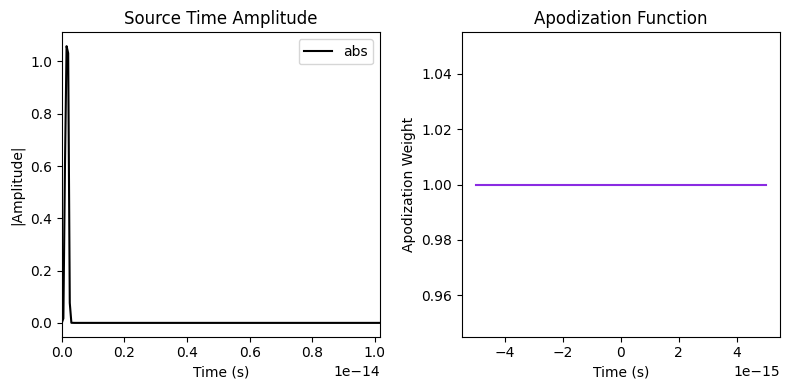

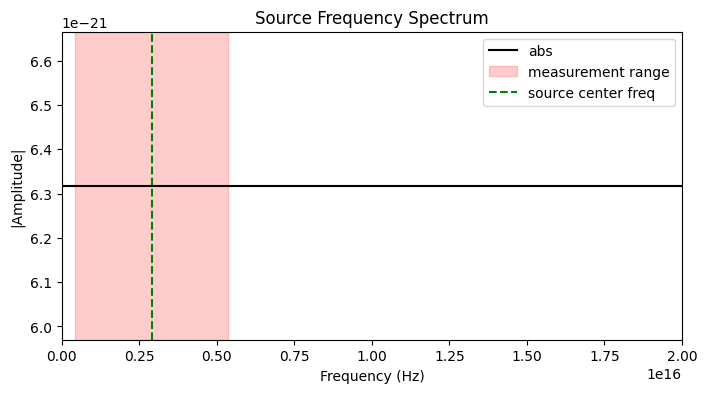

In [11]:
plot_sim = sim
plot_time = 5e1 / freq_width

# Check source amplitude and spectrum
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))

#####===== Time graph for source amplitude =======####
ax1 = plot_sim.sources[0].source_time.plot(
    times=np.linspace(0, plot_time, 200), 
    val="abs", 
    ax=ax1)
ax1.set_xlim(0, plot_time)
ax1.set_title('Source Time Amplitude')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('|Amplitude|')

# Plot over the full run_time to see the apodization window
times_apod = np.linspace(-Run_time/100, Run_time/100, 1000)

ax2 = val_Apodization.plot(times=times_apod, ax=ax2)
ax2.set_title('Apodization Function')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Apodization Weight')
plt.show()


####===== Frequency range for source dipoles =====####
fig, ax3 = plt.subplots(1, 1, figsize=(8, 4))
ax3 = plot_sim.sources[0].source_time.plot_spectrum(      # source spectrum
    times=np.linspace(0, plot_sim.run_time, 1001), 
    num_freqs = 201,
    val="abs", 
    ax=ax3)
ax3.set_xlim(0, 2e16)

# Highlight measurement frequency range
ax3.axvspan(freq_min, freq_max, alpha=0.2, color='red', # measurement range
            label='measurement range')
ax3.axvline(freq_0, color='green', linestyle='--', 
            label='source center freq')
ax3.legend()
ax3.set_title('Source Frequency Spectrum')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('|Amplitude|')
plt.show()

# After plotting, check the source spectrum values at your freq range
# source_spectrum_min = plot_sim.sources[0].source_time.spectrum(
#     freq_min, plot_sim.run_time, 10001)
# source_spectrum_max = plot_sim.sources[0].source_time.spectrum(
#     freq_max, plot_sim.run_time, 10001)
# print(plot_sim.sources[0].source_time.fwidth)
# print(plot_sim.sources[0].source_time.f0)

# print(ev_to_hz(22)/1e16, ev_to_hz(2)/1e16)  # 22eV and 2eV

# Validation and checking before submission

In [27]:
print(f'radius{rad:.3f}, height{thickness:.3f}, dipole{pol_value}')
sim.plot_3d()

radius0.030, height0.025, dipoleEx


# Run simulations

In [13]:
# Estimate cost of your simulation before running
estimated_cost = td.web.estimate_cost(sim)
print(f"Estimated simulation cost: {estimated_cost} credits")

07:19:42 UTC WARNING: No connection: Retrying for 180 seconds.                  

07:22:41 UTC ERROR: No internet connection: giving up on connection waiting.    

WebError: No internet connection: giving up on connection waiting.

In [28]:
###### ===============================#############
######=========  RUN Simulations ===========####

sim_data = web.run(
    sim, 
    task_name=name, 
    path=save_dir +name+'.hdf5',
    verbose=True)

sim_data0 = web.run(
    sim0, 
    task_name= name0, 
    path=save_dir +name0+'.hdf5',
    verbose=True)

07:58:07 UTC Created task '/miniMon_dipolEx_L25_Hxyz' with task_id              
             'fdve-5c594203-160f-4ee6-8cad-f037690acef9' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=301602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=268845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\taskId]8;;\]8;id=301602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\=]8;;\]8;id=523809;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\fdve]8;;\]8;id=301602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\-5c594203-160]8;;\
             ]8;id=301602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\f-4ee6-8cad-f037690acef9']8;;\.

             Task folder: ]8;id=600382;https://tidy3d.simulation.cloud/folders/folder-afab32be-d0bb-4534-b56b-64f433720581\'default']8;;\.

Output()

07:58:11 UTC Maximum FlexCredit cost: 0.679. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

07:58:13 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

07:58:18 UTC status = preprocess

07:58:23 UTC starting up solver

             running solver

Output()

07:58:32 UTC early shutoff detected at 4%, exiting.

07:58:33 UTC status = postprocess

Output()

07:58:44 UTC status = success

07:58:46 UTC View simulation result at                                          
             ]8;id=904462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=304710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\taskId]8;;\]8;id=904462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\=]8;;\]8;id=754411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\fdve]8;;\]8;id=904462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\-5c594203-160]8;;\
             ]8;id=904462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c594203-160f-4ee6-8cad-f037690acef9\f-4ee6-8cad-f037690acef9']8;;\.

Output()

08:00:34 UTC loading simulation from                                            
             /app/local_project/siHoles_offset/miniMon_dipolEx_L25_Hxyz.hdf5

08:00:37 UTC Created task '/miniMon_dipolEx_L25_Hxyz_empty' with task_id        
             'fdve-250daa24-7e69-4a36-ab6d-81803ae27412' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=974935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=693837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\taskId]8;;\]8;id=974935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\=]8;;\]8;id=113850;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\fdve]8;;\]8;id=974935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\-250daa24-7e6]8;;\
             ]8;id=974935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\9-4a36-ab6d-81803ae27412']8;;\.

             Task folder: ]8;id=541515;https://tidy3d.simulation.cloud/folders/folder-afab32be-d0bb-4534-b56b-64f433720581\'default']8;;\.

Output()

08:00:41 UTC Maximum FlexCredit cost: 0.567. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

08:00:42 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:00:48 UTC status = preprocess

08:00:52 UTC starting up solver

             running solver

Output()

08:01:12 UTC early shutoff detected at 4%, exiting.

             status = postprocess

Output()

08:01:22 UTC status = success

08:01:24 UTC View simulation result at                                          
             ]8;id=547591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=300325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\taskId]8;;\]8;id=547591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\=]8;;\]8;id=622805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\fdve]8;;\]8;id=547591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\-250daa24-7e6]8;;\
             ]8;id=547591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-250daa24-7e69-4a36-ab6d-81803ae27412\9-4a36-ab6d-81803ae27412']8;;\.

Output()

08:03:06 UTC loading simulation from                                            
             /app/local_project/siHoles_offset/miniMon_dipolEx_L25_Hxyz_empty.hd
             f5